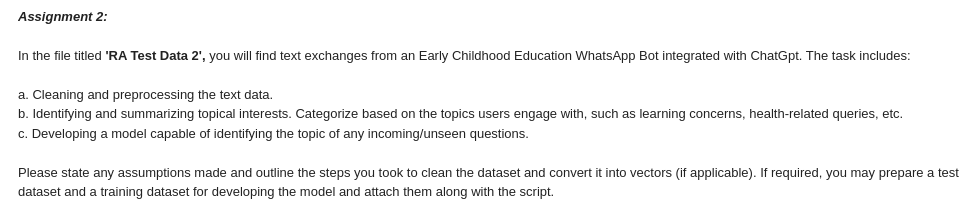

There can be two approaches- we can also learn from the response and summarize the topical interests and then develop a label column. Later we can build the model on questions_asked with label as target column- that would be supervised learning model. First lets find/ categorize the topical interests based on text questions as well as response, Later lets see how to build the model

# Imports

In [ ]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# import regex module
import re

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer


# display all the columns in dataframe
pd.set_option('display.max_columns', None)

# import spacy
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# import seaborn
import seaborn as sns

import warnings
# Ignore all warnings (like convergence..) by sklearn
def warn(*args, **kwargs):
  pass
warnings.warn = warn


## import wordcloud
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 1. Get the data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/aps0611/pratham_research/main/raw/RA%20TestData%202.csv")
data.head(5)

,chat_id,question_translated,text_response
0,1000,What is NCF?,The National ECCE Curriculum Framework is a do...
1,1014,The girl has diarrhoea,Here is a resource link for a video in Hindi t...
2,1021,My child has a fever. What do I do?,"If your child has a fever, it is important to ..."
3,1022,Yes it is,"As an AI language model, my policy is to provi..."
4,1023,My child has a fever. What do I do?,"If your child has a fever, it is important to ..."


In [ ]:
data.shape

(927, 3)

In [ ]:
data.chat_id.value_counts()

chat_id
654     2
700     2
720     2
719     2
718     2
       ..
1830    1
1831    1
1832    1
1834    1
999     1
Name: count, Length: 830, dtype: int64

In [ ]:
data.question_translated.value_counts()

question_translated
What is the National Curriculum Framework for ece?                    39
What's Stunning                                                       17
What is Early Childhood Education?                                    14
1                                                                     11
My child has diarrhea What should I do?                               11
                                                                      ..
My son's hands are very thin                                           1
My daughter is having trouble with her period, suggest a solution.     1
My son is angry.                                                       1
My child is suffering from constipation                                1
T                                                                      1
Name: count, Length: 606, dtype: int64

# 2. Data Cleaning and Preprocessing

In [ ]:
df = data.copy()

In [ ]:
# check if there are any nan values

df.isna().sum()

chat_id                0
question_translated    0
text_response          0
dtype: int64

In [ ]:
## lets get the list of stop words from public github repo
## https://github.com/stanfordnlp/CoreNLP/blob/main/data/edu/stanford/nlp/patterns/surface/stopwords.txt
my_stop_words = [
    "!!", "?!", "??", "!?", "`", "``", "''", "-lrb-", "-rrb-", "-lsb-", "-rsb-",
    ",", ".", ":", ";", '"', "'", "?", "<", ">", "{", "}", "[", "]", "+", "-",
    "(", ")", "&", "%", "$", "@", "!", "^", "#", "*", "..", "...",
    "ll", "s", "'m", "a", "about", "above", "after", "again", "against", "all",
    "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
    "before", "being", "below", "between", "both", "but", "by", "can",
    "could", "did",
    "doing", "down", "during", "each", "for", "from", "further",
    "had", "has", "have", "having", "he", "hed",
    "hell", "hes", "her", "here", "heres", "hers", "herself", "him", "himself",
    "his", "how", "hows", "i", "id", "ill", "im", "ive", "if", "in", "into",
    "is", "it", "its", "itself", "lets", "me", "more", "most",
    "my", "myself","nor", "of", "on", "only",
    "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same",
    "shant", "she", "shed", "shell", "shes", "should", "shouldnt", "so", "some",
    "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves",
    "then", "there", "theres", "these", "they", "theyd", "theyll", "theyre",
    "theyve", "this", "those", "through", "to", "too", "until", "up",
    "very", "was", "we", "wed", "well", "were", "weve", "were",
    "what", "whats", "when", "whens", "where", "wheres", "which",
    "while", "who", "whos", "whom", "why", "whys", "with", "wont", "would",
    "wouldnt", "you", "youd", "youll", "youre", "youve", "your", "yours",
    "yourself", "yourselves", "###", "return", "arent",
    "hes", "heres", "hows", "im",
    "its", "lets", "mustnt", "shant", "shes", "thats", "theres",
    "theyll", "theyre", "theyve", "were", "whats", "whens", "wheres",
    "whos", "whys", "youd", "youll", "youre", "youve",
    "also","across","will","do"
]

In [ ]:
## we can see that question_translated and text_response are not in lower_case

def textPreprocessing(line, stopwords=[]):
    '''
    This function performs following textpreprocessing
    1. lower-string the text
    2. removes apostrophe, http links, hyphen, special characters
    4. removes any numeric characters from text
    3. removes stop words
    '''
    # Lower the string
    line = str(line).lower()

    # remove apostrophe
    line = line.replace('\'','')

    # remove the links
    line = re.sub(r'https?:\S+', ' ', line)

    # remove '-'
    line = re.sub(r'-', ' ', line)

    # Using regex to remove all the Special Characters and numeric characters:
    line = re.sub(r'[^a-z\s]', '', line)

    # remove consecutive double spaces
    cleanLine = re.sub(r'\s+', ' ', line).strip()

    # Tokenize the text
    tokens = word_tokenize(cleanLine)

    # Lemmantize and remove the stop words
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stopwords]

    cleanLine = ' '.join(filtered_tokens)

    return cleanLine

In [ ]:
## apply the text preprocessing on the question_translated column
df['question_translated'] = df['question_translated'].apply(lambda x:textPreprocessing(x,stopwords = my_stop_words))
df['text_response'] = df['text_response'].apply(lambda x:textPreprocessing(x,stopwords = my_stop_words))

In [ ]:
df.head()

,chat_id,question_translated,text_response
0,1000,ncf,national ecce curriculum framework document cr...
1,1014,girl ha diarrhoea,resource link video hindi discus major cause s...
2,1021,child ha fever,child ha fever important monitor temperature p...
3,1022,yes,ai language model policy provide best answer p...
4,1023,child ha fever,child ha fever important monitor temperature p...


In [ ]:
data[data.question_translated == '1']

,chat_id,question_translated,text_response
123,1174,1,"I'm sorry, but the context you provided does n..."
202,1597,1,"To keep the answer short, it's important to fo..."
339,2011,1,"Hello! I am BaalSakhi, an early childhood chat..."
462,365,1,The variable <langchain.vectorstores.faiss.FAI...
475,390,1,I can provide several resource links related t...
478,401,1,When answering questions as an early childhood...
823,774,1,"As an early childhood chatbot, it is important..."
857,802,1,The request is to answer the user's question u...
873,825,1,"I apologize, but I cannot answer your question..."
881,836,1,"I'm sorry, could you please provide me with a ..."


## Lets check if the question_translated column contains any NaN values after our cleaning operation

In [ ]:
df[df.question_translated == '']

,chat_id,question_translated,text_response
113,1163,,keep answer short summarizing main topic cover...
115,1165,,keep answer short adding relevant resource lin...
123,1174,,sorry context provided doe not relate question...
194,1586,,relevant resource link added short answer earl...
201,1596,,ai language model always strive provide short ...
202,1597,,keep answer short important focus directly ans...
224,1666,,relevant resource link added short answer earl...
242,1761,,ai language model always strive provide short ...
245,1772,,apologize confusion information provided varia...
292,1872,,


In [ ]:
## lets drop these 27 rows as they contain unnecessary noise

In [ ]:
# df[df.question_translated == ''].index

In [ ]:
# data[data.index.isin(df[df.question_translated == ''].index)] ## these index are important as they can be modelled into one single label

In [ ]:
# df.drop(df[df.question_translated == ''].index, inplace=True)

In [ ]:
# df[df.question_translated == ''].index # that means we have correctly removed all the empty rows

In [ ]:
#create combined string of all the questions
question_corpus = ""
for row in df.question_translated:
    question_corpus = question_corpus+" "+row

In [ ]:
question_corpus

' ncf girl ha diarrhoea child ha fever yes child ha fever child usually learn walk keep mind teething child hamara gaon poster involve section society bal shiksha help child education involvement uneducated mother child education motivate parent educate child balsakhi balsakhi matao ki bhumika dast ke dauran bacchon ka khayal kaise rakhte hain early childhood education capital kerala national curriculum framework ece early childhood education child obese early childhood education early childhood education ece early childhood education early childhood education developmental milestone child early childhood education motor skill age child start eating rice national curriculum framework ece bal bachpan dast government scheme reduce low birth weight child national curriculum framework ece motor skill national curriculum framework ece developmental milestone child early childhood education food fortification national curriculum early childhood education national curriculum framework ece foo

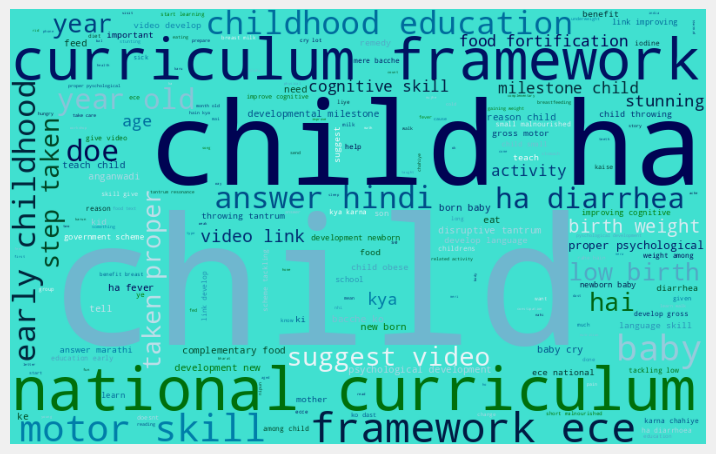

In [ ]:
wc = WordCloud(width = 800, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(question_corpus)
plt.imshow(wc);
plt.axis('off')
plt.show()


In [ ]:
df.question_translated.value_counts()

question_translated
national curriculum framework ece           47
                                            32
motor skill                                 23
early childhood education                   23
child ha diarrhea                           18
                                            ..
child ha hearing loss suggest solution       1
child ha high fever suggest remedy           1
child ha difficulty defecating               1
child doe not feel hungry suggest remedy     1
t                                            1
Name: count, Length: 530, dtype: int64

In [ ]:
#create combined string of all the response
response_corpus = ""
for row in df.text_response:
    response_corpus = response_corpus+" "+row

In [ ]:
response_corpus

' national ecce curriculum framework document created ministry woman child development india outline principle objective goal early childhood care education country draw idea experience many individual group including government official educator child development expert framework cover topic theoretical foundation ecce curricular issue concern guiding principle program planning link national ecce curriculum framework resource link video hindi discus major cause solution diarrhea child additionally following resource link cover topic related holistic development health nutrition growth development habit child including diarrhea half minute fight diarrhea safe drinking water child nutrition iodine necessary worm diarrhea vaccination child ha fever important monitor temperature provide plenty fluid prevent dehydration give counter fever reducer like acetaminophen ibuprofen make sure follow recommended dosage age weight fever persists child show symptom like difficulty breathing rash impo

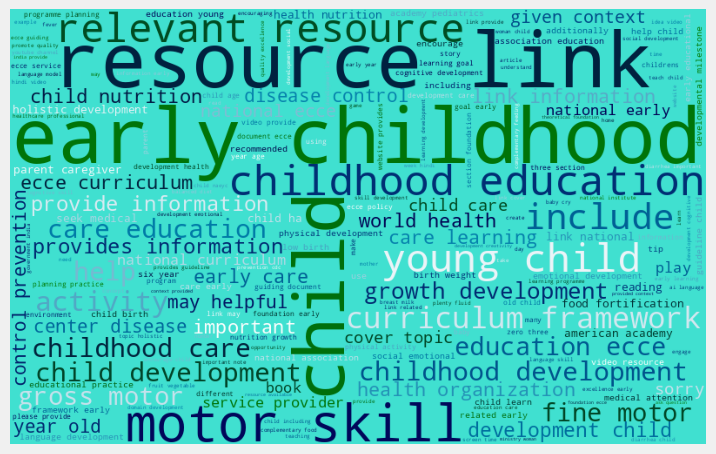

In [ ]:
wc = WordCloud(width = 800, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(response_corpus)
plt.imshow(wc);
plt.axis('off')
plt.show()


Here we can manually do the modelling but, will be difficult when the data is huge. Lets do one thing, lets do the topic modelling based on the gpt response

# Latent Dirichlet Allocation[LDA]

In [ ]:
from gensim import corpora, models
from gensim.models import Phrases

In [ ]:
#tokenize articles
tokenize_text = df.question_translated.apply(lambda x : x.split())

# Create bigrams and trigrams
bigram = Phrases(tokenize_text, min_count=4, threshold=100)
trigram = Phrases(bigram[tokenize_text], min_count=4, threshold=100)

# Add bigrams and trigrams to tokenized text
tokenized_text = list(trigram[bigram[tokenize_text]])

id2word = corpora.Dictionary(tokenize_text)

# Create Corpus
texts = tokenize_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Create TF-IDF model
tfidf = models.TfidfModel(corpus)

# Apply TF-IDF transformation to the corpus
corpus_tfidf = tfidf[corpus]

#printing words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[1][:50]

[('diarrhoea', 1), ('girl', 1), ('ha', 1)]

In [ ]:
# tokenized_text

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           )

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"child" + 0.042*"answer" + 0.037*"hindi" + 0.015*"ha" + '
  '0.015*"weight" + 0.015*"not" + 0.015*"eat" + 0.013*"baby" + 0.013*"kya" + '
  '0.013*"disruptive"'),
 (1,
  '0.123*"child" + 0.055*"ece" + 0.053*"national" + 0.053*"curriculum" + '
  '0.051*"framework" + 0.025*"ha" + 0.024*"diarrhea" + 0.019*"food" + '
  '0.012*"skill" + 0.012*"teach"'),
 (2,
  '0.102*"child" + 0.049*"education" + 0.043*"childhood" + 0.041*"early" + '
  '0.026*"milestone" + 0.024*"developmental" + 0.019*"food" + 0.017*"birth" + '
  '0.015*"reason" + 0.013*"weight"'),
 (3,
  '0.096*"child" + 0.022*"year" + 0.018*"development" + 0.018*"education" + '
  '0.015*"baby" + 0.015*"early" + 0.015*"old" + 0.015*"teach" + 0.015*"weight" '
  '+ 0.011*"activity"'),
 (4,
  '0.041*"child" + 0.022*"food" + 0.017*"kya" + 0.017*"tantrum" + 0.016*"baby" '
  '+ 0.015*"give" + 0.015*"activity" + 0.014*"answer" + 0.012*"motor" + '
  '0.012*"year"'),
 (5,
  '0.051*"child" + 0.035*"skill" + 0.033*"motor" + 0.033*"ece" 

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.097753 -0.035122       1        1  17.707779
6     -0.103476  0.094964       2        1  16.157976
3      0.044045 -0.076552       3        1  12.571136
2     -0.021807 -0.153292       4        1  11.729397
5     -0.085877  0.033033       5        1  10.984392
7      0.142491  0.024623       6        1  10.474501
0      0.073416  0.010221       7        1  10.394169
4      0.048960  0.102124       8        1   9.980649, topic_info=              Term       Freq      Total Category  logprob  loglift
47             ece  46.000000  46.000000  Default  30.0000  30.0000
49        national  35.000000  35.000000  Default  29.0000  29.0000
48       framework  34.000000  34.000000  Default  28.0000  28.0000
46      curriculum  36.000000  36.000000  Default  27.0000  27.0000
54           skill  53.000000  53.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
73         benefit   2.496688  12.722148   Topic8  -4.8855   0.6761
67   fortification   2.495925  13.663391   Topic8  -4.8858   0.6045
3               ha   3.299453  51.452985   Topic8  -4.6067  -0.4424
54           skill   3.298211  53.880022   Topic8  -4.6071  -0.4889
159            hai   2.497163  16.283348   Topic8  -4.8853   0.4295

[536 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
577       3  0.583354   aadhaar
221       3  0.295402      ache
221       6  0.590805      ache
677       5  0.620526     achhi
152       1  0.057560  activity
...     ...       ...       ...
85        7  0.054487      year
85        8  0.108975      year
6         2  0.160893       yes
6         3  0.804465       yes
397       1  0.661857        yr

[804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 3, 6, 8, 1, 5])

n: 2; alpha: symmetric; beta: auto; Score: 0.5887260857057619
n: 2; alpha: symmetric; beta: 0.3; Score: 0.578296584106599
n: 2; alpha: symmetric; beta: 0.5; Score: 0.5887260857057619
n: 2; alpha: symmetric; beta: 0.7; Score: 0.5887260857057619
n: 2; alpha: 0.3; beta: auto; Score: 0.5729392715976376
n: 2; alpha: 0.3; beta: 0.3; Score: 0.570402900173483
n: 2; alpha: 0.3; beta: 0.5; Score: 0.5729392715976376
n: 2; alpha: 0.3; beta: 0.7; Score: 0.5713936679603199
n: 2; alpha: 0.5; beta: auto; Score: 0.5887260857057619
n: 2; alpha: 0.5; beta: 0.3; Score: 0.578296584106599
n: 2; alpha: 0.5; beta: 0.5; Score: 0.5887260857057619
n: 2; alpha: 0.5; beta: 0.7; Score: 0.5887260857057619
n: 2; alpha: 0.7; beta: auto; Score: 0.5849034760397789
n: 2; alpha: 0.7; beta: 0.3; Score: 0.5925672841535217
n: 2; alpha: 0.7; beta: 0.5; Score: 0.5849034760397789
n: 2; alpha: 0.7; beta: 0.7; Score: 0.5743280461662406
n: 3; alpha: symmetric; beta: auto; Score: 0.5526497511156812
n: 3; alpha: symmetric; beta: 0.3

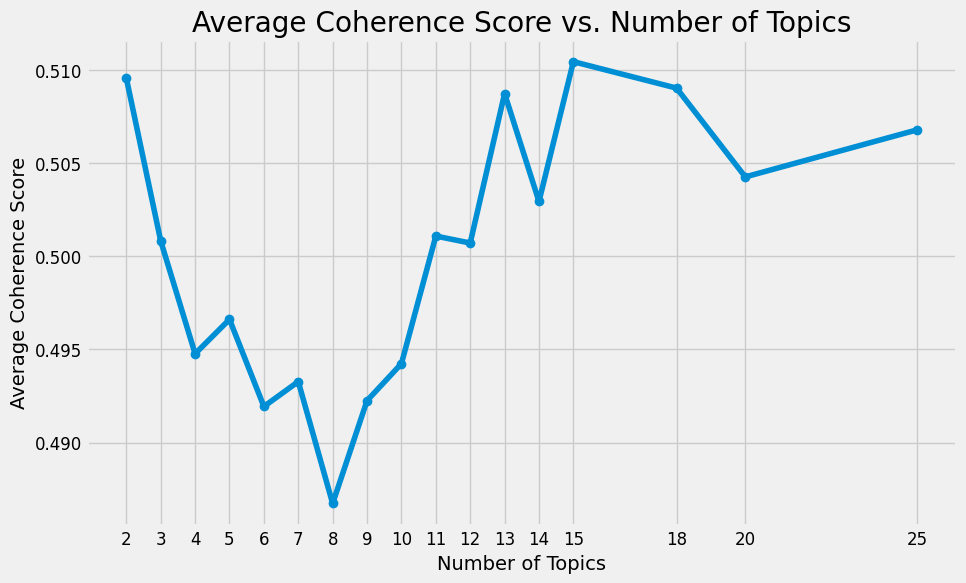

In [ ]:
# Define a function to calculate coherence score for a given set of hyperparameters
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha=alpha,
                                                per_word_topics=True,
                                                eta=beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# List containing various hyperparameters
no_of_topics = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 18, 20, 25]
alpha_list = ['symmetric', 0.3, 0.5, 0.7]
beta_list = ['auto', 0.3, 0.5, 0.7]

# Initialize lists to store coherence scores and corresponding hyperparameters
coherence_scores = []
hyperparameters = []

# Loop through hyperparameters and calculate coherence scores
for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            coherence_scores.append(coherence_score)
            hyperparameters.append((n, alpha, beta))
            print(f"n: {n}; alpha: {alpha}; beta: {beta}; Score: {coherence_score}")

# Calculate average coherence score for each number of topics
avg_coherence_per_topic = {}
for i, n in enumerate(no_of_topics):
    avg_coherence = sum(coherence_scores[i::len(no_of_topics)]) / len(alpha_list) / len(beta_list)
    avg_coherence_per_topic[n] = avg_coherence

# Plot average coherence score vs. number of topics
plt.figure(figsize=(10, 6))
plt.plot(avg_coherence_per_topic.keys(), avg_coherence_per_topic.values(), marker='o')
plt.title('Average Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.grid(True)
plt.xticks(no_of_topics)
plt.show()

n: 5; alpha: 0.5; beta: 0.5; Score: 0.5307156359529631
n: 10; alpha: 0.7; beta: auto; Score: 0.5497993719727868


In [ ]:
n = 11
alpha = 0.3
beta = 0.3
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.506542622639073


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.257181  0.016149       1        1  12.528085
7      0.036112 -0.021344       2        1  10.865975
6      0.044758 -0.055467       3        1  10.809025
9      0.023299 -0.014372       4        1   9.809745
1      0.042910 -0.160012       5        1   8.916625
3     -0.103493  0.000677       6        1   8.820813
10     0.066672  0.174209       7        1   8.412619
0      0.024473  0.003520       8        1   7.861742
5      0.036425 -0.024871       9        1   7.796609
2      0.048751  0.073576      10        1   7.506788
4      0.037275  0.007935      11        1   6.671975, topic_info=           Term        Freq       Total Category  logprob  loglift
4         child  175.000000  175.000000  Default  30.0000  30.0000
47          ece   40.000000   40.000000  Default  29.0000  29.0000
46   curriculum   35.000000   35.000000  Default  28.0000  28.0000
49     national   35.000000   35.000000  Default  27.0000  27.0000
48    framework   35.000000   35.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
297         get    3.102106    4.808872  Topic11  -4.2657   2.2689
503         lot    3.245288    5.214942  Topic11  -4.2205   2.2329
603        test    1.385341    3.091395  Topic11  -5.0718   1.9046
224        pain    1.300651    3.004151  Topic11  -5.1349   1.8701
764      report    3.178714   11.502540  Topic11  -4.2413   1.4212

[369 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
797      10  0.722732  abbreviation
625       9  0.414895           ace
152       7  0.903948      activity
166       8  0.382512     admission
55        7  0.663561           age
...     ...       ...           ...
65        6  0.927187        weight
253       7  0.578613       writing
85        3  0.950780          year
6         6  0.908161           yes
277       1  0.390510         young

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 7, 10, 2, 4, 11, 1, 6, 3, 5])

In [ ]:
# Get the top 5 words for each topic
top_words_per_topic = []
for topic_id, words in lda_model.show_topics(num_topics=n, num_words=5, formatted=False):
    top_words_per_topic.append([word[0] for word in words])

# Print or use the top words
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(top_words)}")

In [ ]:
n = 10
alpha = 0.7
beta = 'auto'
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

In [ ]:
# Get the top 5 words for each topic
top_words_per_topic = []
for topic_id, words in lda_model.show_topics(num_topics=n, num_words=5, formatted=False):
    top_words_per_topic.append([word[0] for word in words])

# Print or use the top words
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(top_words)}")